In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import covariance_generation as cov
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [2]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)

other_curves_dict = {'Ablimit et al. (2020) - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. (2020) - \n3D velocity method' : cepheids_vel_method,
                    'Wang et al. (2022)' : vc_data_wang,
                    'Eilers et al. (2018)' : eilers_rc}

In [3]:
# Rotation Curve Plotting Function

def plot_rotation_curve(is_fit_curve, 
                        mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False, 
                        is_h_fitted = True):

    def func(x, a, b, c, ):
        return a*x*x + b*x + c

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'orange', 'blue', 'green', 'red']
    
    for i_path, path in enumerate(mcmc_runs):

        
        bin_setup = load_bin_settings(path, is_print=False)
        bin_centers_r = bin_setup['bin_centers_r']

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-200, 200, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt='o', c=colors[i_path], label=labels[i_path])

        if(is_fit_curve):
            popt, pcov = curve_fit(func, bin_centers_r, -y_values, sigma=velocity_array[:,1])
            perr = np.sqrt(np.diag(pcov))
            fit = func(np.array(bin_centers_r), popt[0], popt[1], popt[2])
            plot(bin_centers_r, fit, colors[i_path], lw=2, linestyle="-", alpha=0.75, label='Fitted curve')

    plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]
    bin_edges_z = bin_setup['bin_edges'][1].T[0]

    if(display_bin_edges):
        # y_min = np.min(y_values)
        # y_max = np.max(y_values)

        ax.vlines(bin_edges_r, 205, 250, linestyles='dashed', alpha=0.5, colors='grey')
        
        x_ticks = np.round(bin_edges_r)
        #x_ticks = np.insert(x_ticks, 0, 4300)
        #x_ticks = np.insert(x_ticks, -1, 12700)
        ax.set_xticks(x_ticks)


    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 16]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)
            
            if(key == 'Eilers et al. (2018)'):
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            plt.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt='v',
                    label=key)
    plt.legend(prop={'size': 7})
 
    r_range = r', $r \in [{},{}]$ kpc'.format(np.round(bin_edges_r[0]/1000), np.round(bin_edges_r[-1]/1000))
    z_range = r', $z \in [{},{}]$ pc'.format(np.round(bin_edges_z[0]), np.round(bin_edges_z[-1]))
    #plt.title('Rotation Curve' + r_range + z_range, fontsize=18, pad=12)

    plt.xlim(4000, 16000)

def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

---
# Curves With Varying $R_0$

In [19]:
# R_0 = 7.8 kpc
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-09-53_range0.3'

# R_0 = 8.275 kpc
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-16-18-18-52_range0.3'

# R_0 = 8.5 kpc
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-48-32_range0.3'

paths=[path1, path2, path3]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path3, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']


1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1       ]
 [258.33836858]
 [  8.82356495]]
6. R_0= 8500
7. Z_0= 25
8. cut_range= 0.3
9. final_sample_size= (1717442, 14)
10. disk_scale= 3000.0
11. vlos_dispersion_scale= 21000.0
12. A_r_info= [(5500.0, None), (6500.0, None), (7500.0, None), (8500.0, None), (9500.0, None), (10500.0, None), (11500.0, None), (12500.0, None), (13500.0, None), (14500.0, None)]


Sampler shape: (15000, 48, 12)


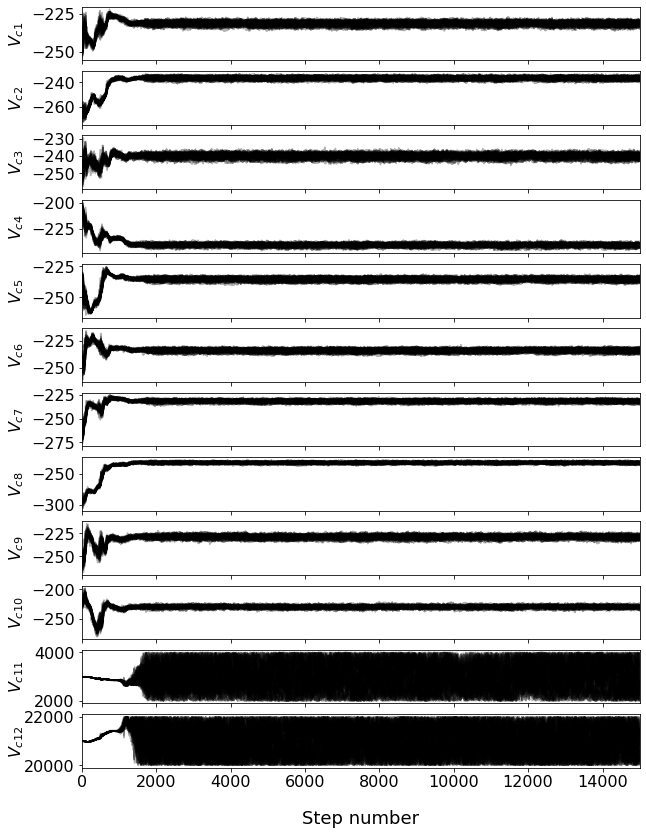

In [11]:
plot_walkers(samplers[1], 0)

R, v_c, sig-, sig+
5.5 219.2 1.8 1.1
6.5 223.7 1.8 1.1
7.5 225.5 1.9 1.2
8.5 222.3 2.0 1.2
9.5 220.2 2.1 1.3
10.5 218.0 2.1 1.3
11.5 217.9 2.0 1.2
12.5 215.7 2.1 1.3
13.5 213.7 2.7 1.8
14.5 209.5 2.8 2.1
(10,)
(10,)
R, v_c, sig-, sig+
5.5 230.8 1.9 1.3
6.5 236.6 1.8 1.1
7.5 239.7 1.9 1.2
8.5 238.9 2.0 1.3
9.5 235.0 2.1 1.3
10.5 233.9 2.2 1.4
11.5 231.8 2.0 1.3
12.5 231.2 1.9 1.2
13.5 228.5 2.3 1.6
14.5 224.5 2.8 1.9
(10,)
(10,)
R, v_c, sig-, sig+
5.5 235.8 2.1 1.4
6.5 242.5 1.7 1.2
7.5 246.1 1.9 1.2
8.5 246.3 1.8 1.3
9.5 242.6 2.0 1.3
10.5 241.1 2.1 1.4
11.5 238.5 2.0 1.3
12.5 238.6 1.8 1.3
13.5 235.7 2.1 1.5
14.5 231.5 2.5 1.9
(10,)
(10,)


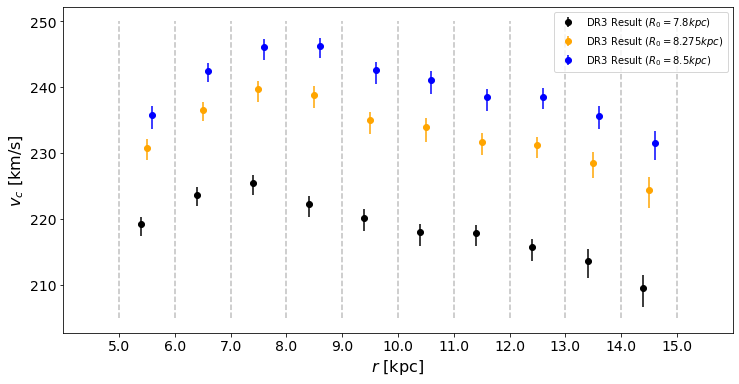

In [22]:
extra_dims = [2, 2, 2]
plot_rotation_curve(False, 
                    paths, 
                    ['DR3 Result ($R_0 = 7.8 kpc$)', 
                    'DR3 Result ($R_0 = 8.275 kpc$)', 
                    'DR3 Result ($R_0 = 8.5 kpc$)'],
                    [4000, 12000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

## Tests With Small Sample (1%)

In [ ]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-09-53_range0.3'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path3, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

Sampler shape: (48000, 48, 13)


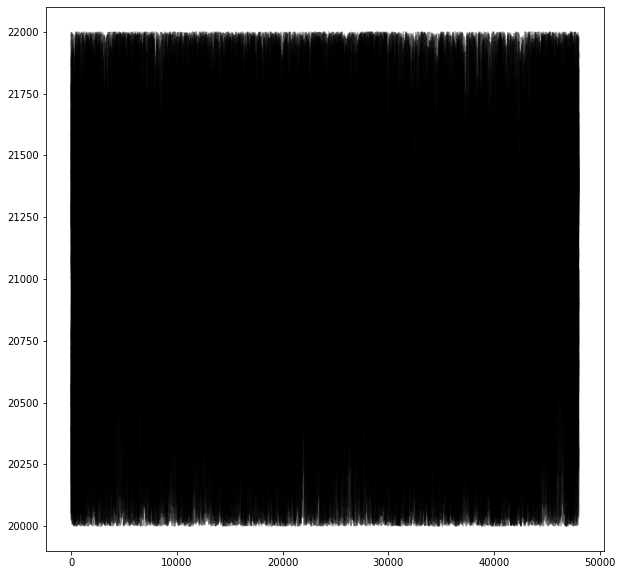

In [12]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-02-15-50-22_48'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')


reader = emcee.backends.HDFBackend(samplers[0], read_only=True)
samples_data = reader.get_chain(discard = 2000)
print("Sampler shape: {}".format(samples_data.shape))

fig,ax = plt.subplots(figsize=(10,10))
 
ax.plot(samples_data[:, :, -2], "k", alpha=0.3)
ax.ticklabel_format(useOffset=False)
plt.show()

Sampler shape: (50000, 48, 13)


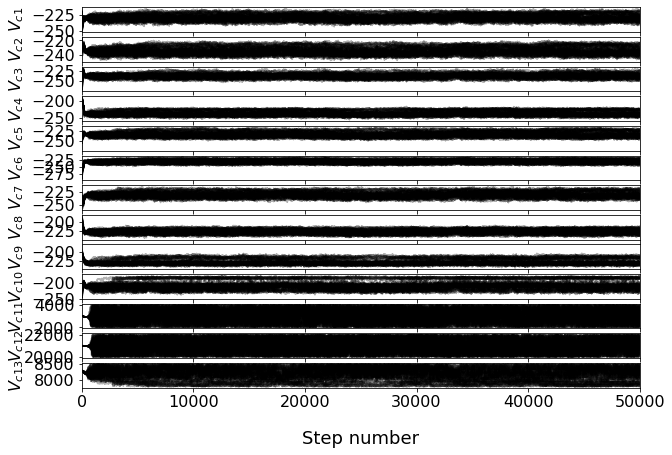

In [4]:
plot_walkers(samplers[0], 0)

Sampler shape: (23000, 48, 13)


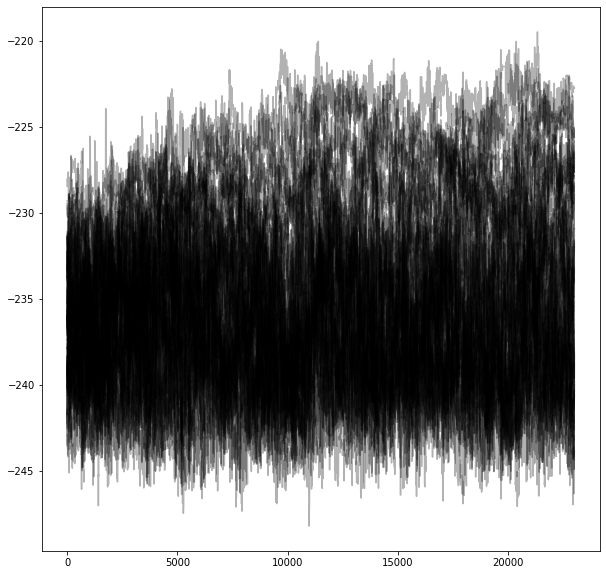

In [3]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-02-23-50-30_48'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')



reader = emcee.backends.HDFBackend(samplers[0], read_only=True)
samples_data = reader.get_chain(discard = 2000)
print("Sampler shape: {}".format(samples_data.shape))

fig,ax = plt.subplots(figsize=(10,10))
 
ax.plot(samples_data[:, :, 1], "k", alpha=0.3)
ax.ticklabel_format(useOffset=False)
plt.show()

Sampler shape: (24997, 48, 13)


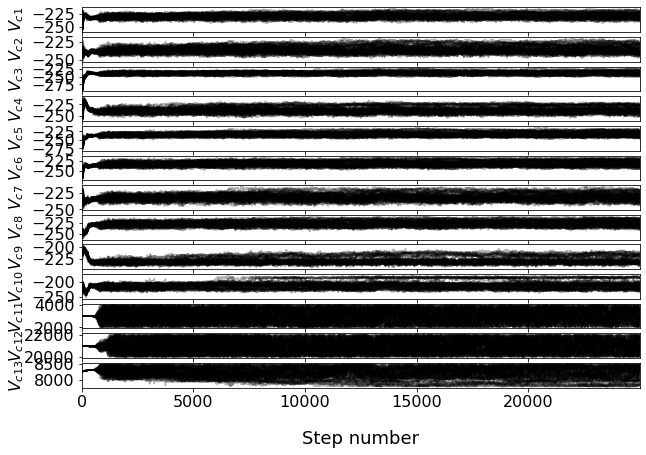

In [5]:
plot_walkers(samplers[0], 3)

# Tests With 10% of Data

In [31]:
# Fitting only h-params - CPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-24-26_48'

# Fitting only h-params - GPU
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-40-35_48'

# Fitting all params - GPU
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-25-27_48'

# R_0 = 7.8 kpc - CPU run
path4 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-12-19-12-09-53_range0.3'

# Fitting only h-params - CPU - after code refacto
path5 = ''

paths=[path1, path2, path3, path4]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (169498, 14)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 1698.6870206849069), (6500.0, 1601.081857629187), (7500.0, 1728.1006902683919), (8500.0, 1789.709481323073), (9500.0, 1858.8133641963743), (10500.0, 1975.2590919652146), (11500.0, 1798.905471840576), (12500.0, 1789.2783824604835), (13500.0, 2456.809

Sampler 1 shape: (15000, 48, 12)
Sampler 2 shape: (15000, 48, 12)


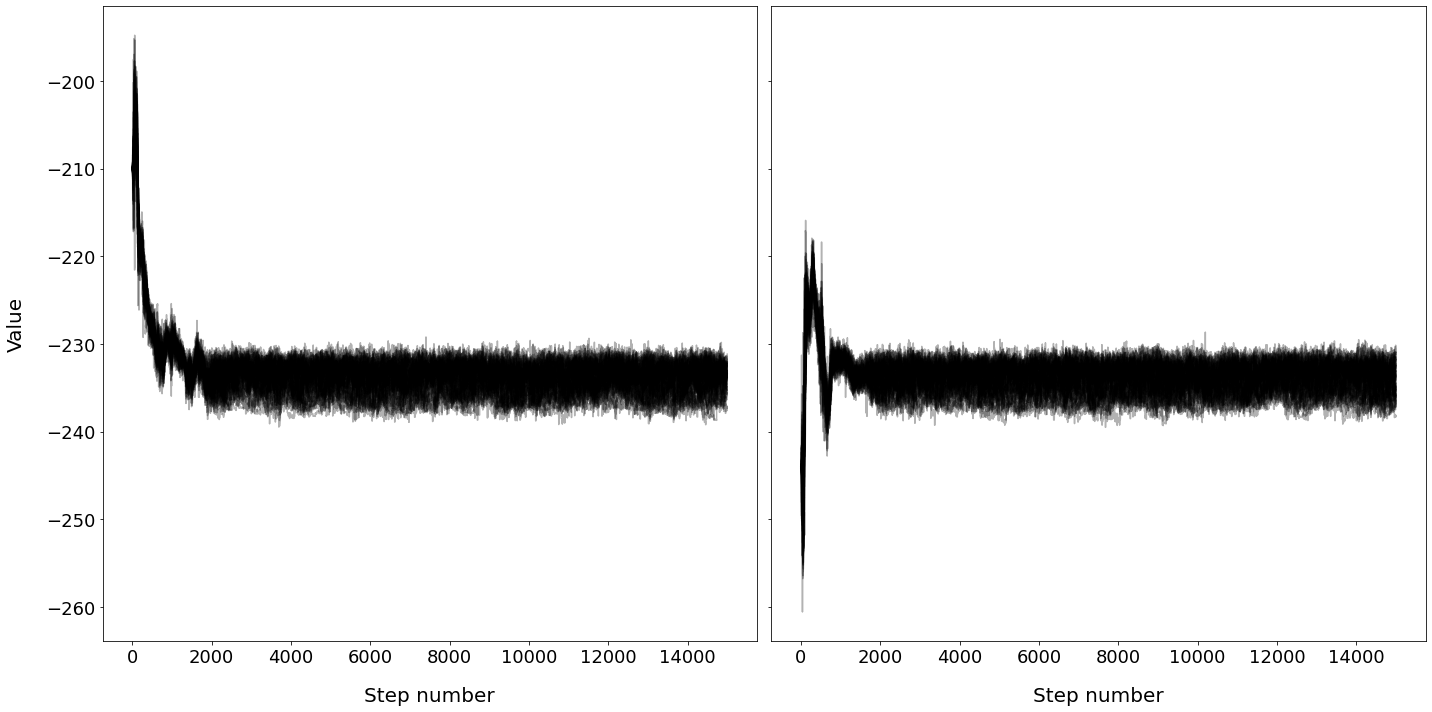

In [37]:
# Comparing results when not fitting R0 for CPU and GPU cases

cpu_run = samplers[0]
gpu_run = samplers[1]
compare_mcmc_runs((cpu_run, gpu_run), 5, 0)

Sampler shape: (15000, 48, 12)
['$V_{c1}$', '$V_{c2}$', '$V_{c3}$', '$V_{c4}$', '$V_{c5}$', '$V_{c6}$', '$V_{c7}$', '$V_{c8}$', '$V_{c9}$', '$V_{c10}$', 'sig_d', 'sig_vr']


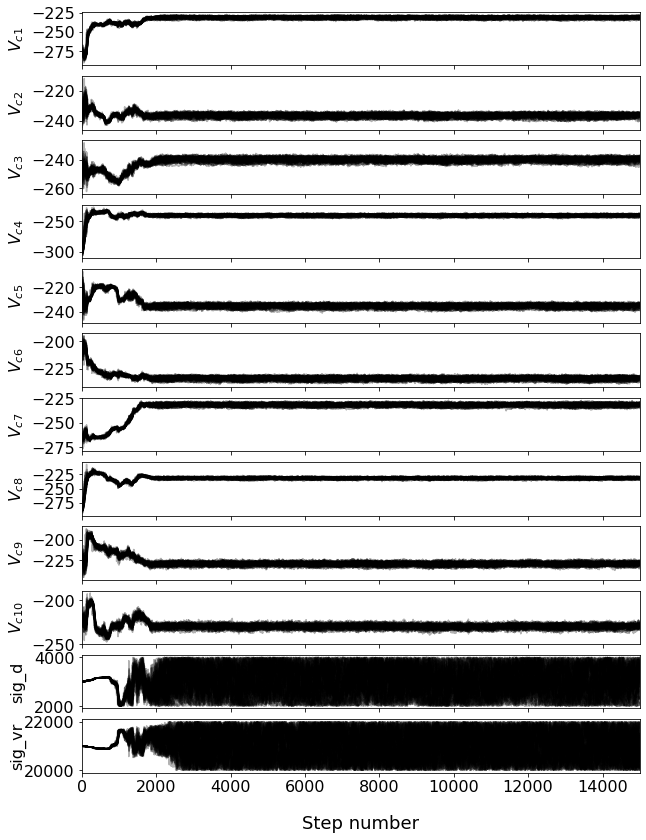

In [60]:
extra_dim_labels = ['sig_d', 'sig_vr']
plot_walkers(samplers[0], 0, extra_dim_labels)

Sampler shape: (15000, 48, 12)
['$V_{c1}$', '$V_{c2}$', '$V_{c3}$', '$V_{c4}$', '$V_{c5}$', '$V_{c6}$', '$V_{c7}$', '$V_{c8}$', '$V_{c9}$', '$V_{c10}$', 'sig_d', 'sig_vr']


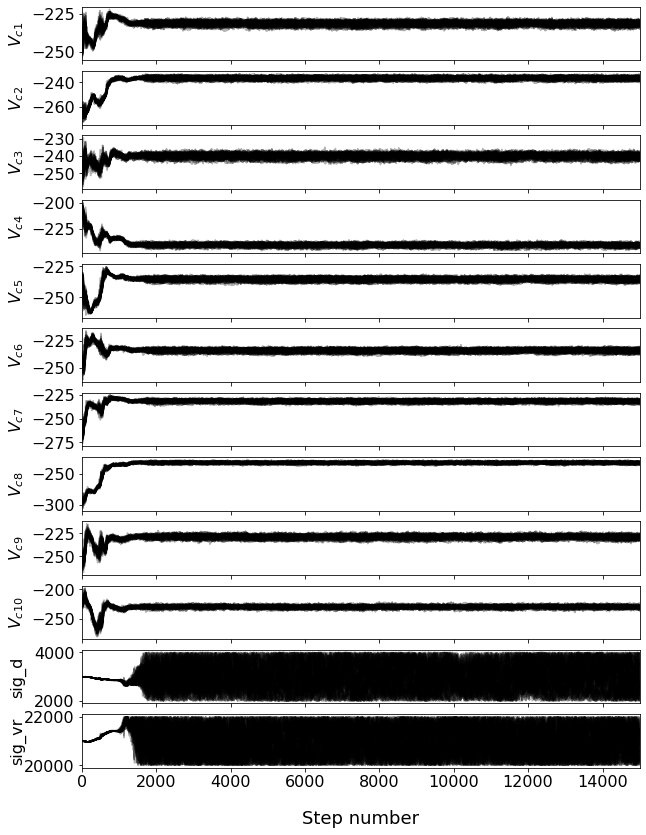

In [62]:
extra_dim_labels = ['sig_d', 'sig_vr']
plot_walkers(samplers[1], 0, extra_dim_labels)

Sampler shape: (13846, 48, 13)
['$V_{c1}$', '$V_{c2}$', '$V_{c3}$', '$V_{c4}$', '$V_{c5}$', '$V_{c6}$', '$V_{c7}$', '$V_{c8}$', '$V_{c9}$', '$V_{c10}$', 'sig_d', 'sig_vr', 'R_0']


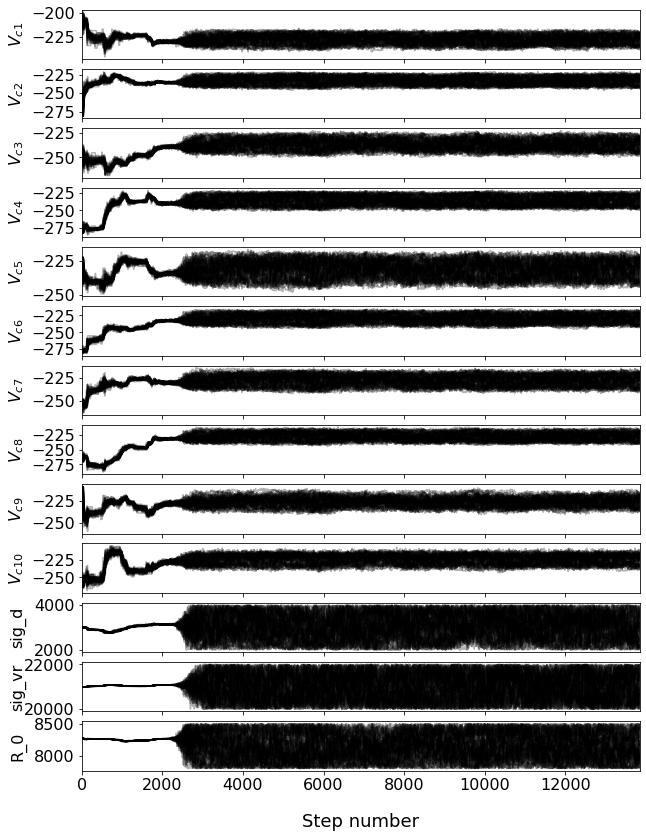

In [65]:
extra_dim_labels = ['sig_d', 'sig_vr', 'R_0']
plot_walkers(samplers[2], 0, extra_dim_labels)

Sampler 1 shape: (15000, 48, 12)
Sampler 2 shape: (13846, 48, 13)


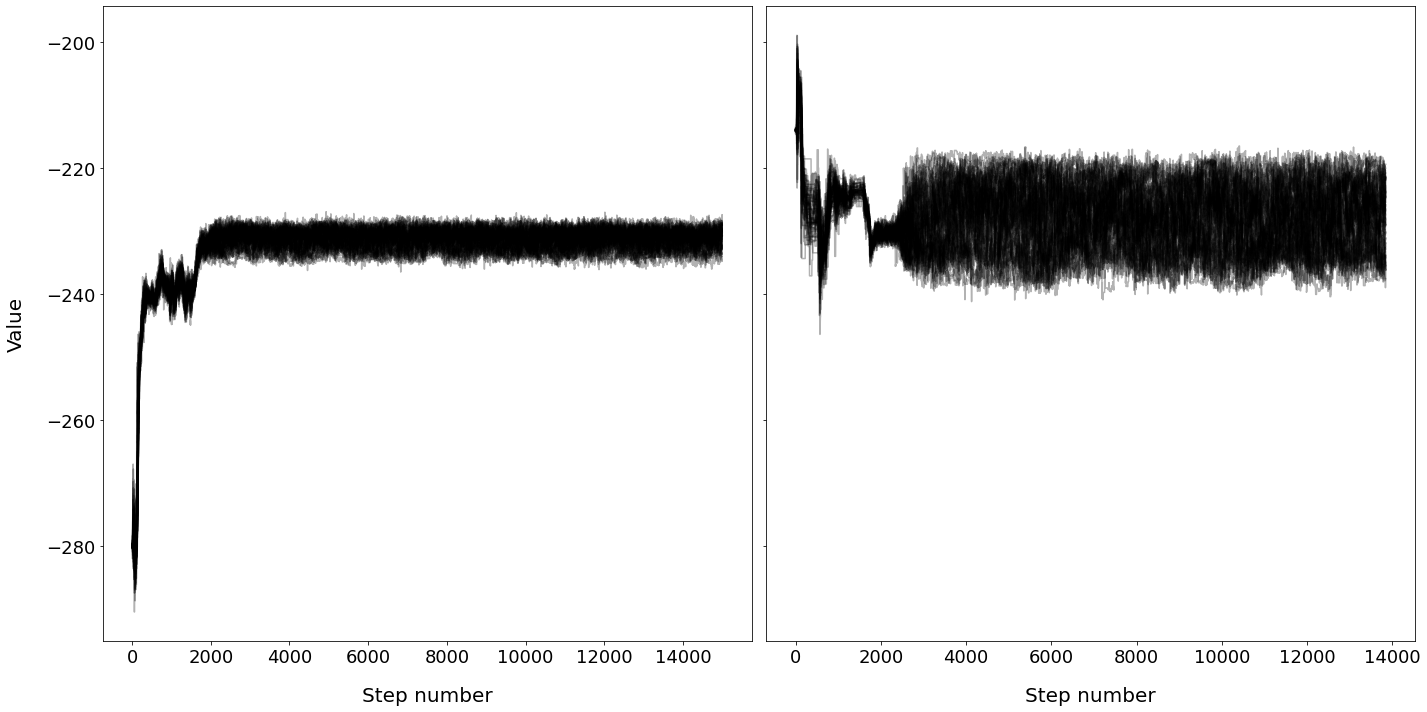

In [5]:
# Comparing results of:
#   1) when not fitting R0 for CPU 
#   2) when fitting for R0 using GPUS

cpu_run = samplers[0]
gpu_run_all_fit = samplers[2]
compare_mcmc_runs((cpu_run, gpu_run_all_fit), bin_idx  = 0, discard=0)

R, v_c, sig-, sig+
5.5 231.1 2.0 1.3
6.5 236.4 1.8 1.2
7.5 239.9 1.9 1.3
8.5 240.7 2.0 1.5
9.5 235.1 2.1 1.4
10.5 233.7 2.2 1.5
11.5 231.4 2.0 1.4
12.5 231.7 1.9 1.4
13.5 228.8 2.6 2.0
14.5 229.6 2.7 2.2
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.1 2.0 1.4
6.5 236.5 1.8 1.3
7.5 239.9 1.9 1.4
8.5 240.8 2.0 1.5
9.5 235.2 2.1 1.4
10.5 233.7 2.2 1.5
11.5 231.4 1.9 1.4
12.5 231.7 1.9 1.5
13.5 228.8 2.6 2.0
14.5 229.8 2.7 2.3
(10,)
(10,)
R, v_c, sig-, sig+
5.5 227.8 6.0 5.7
6.5 233.0 6.6 6.4
7.5 236.9 6.3 6.6
8.5 235.8 8.1 8.8
9.5 231.0 8.1 7.2
10.5 229.5 7.9 7.9
11.5 227.8 7.1 6.5
12.5 227.4 8.0 8.3
13.5 226.3 6.1 5.9
14.5 223.1 9.3 6.1
(10,)
(10,)


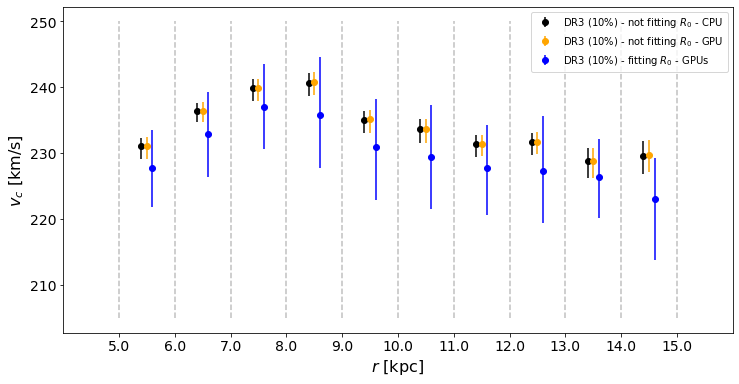

In [33]:
extra_dims = [2, 2, 3]
plot_rotation_curve(False, 
                    paths[0:3], 
                    ['DR3 (10%) - not fitting $R_0$ - CPU', 
                    'DR3 (10%) - not fitting $R_0$ - GPU',
                    'DR3 (10%) - fitting $R_0$ - GPUs'],
                    [4000, 4000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)



R, v_c, sig-, sig+
5.5 231.1 2.0 1.4
6.5 236.5 1.8 1.3
7.5 239.9 1.9 1.4
8.5 240.8 2.0 1.5
9.5 235.2 2.1 1.4
10.5 233.7 2.2 1.5
11.5 231.4 1.9 1.4
12.5 231.7 1.9 1.5
13.5 228.8 2.6 2.0
14.5 229.8 2.7 2.3
(10,)
(10,)
R, v_c, sig-, sig+
5.5 227.8 6.0 5.7
6.5 233.0 6.6 6.4
7.5 236.9 6.3 6.6
8.5 235.8 8.1 8.8
9.5 231.0 8.1 7.2
10.5 229.5 7.9 7.9
11.5 227.8 7.1 6.5
12.5 227.4 8.0 8.3
13.5 226.3 6.1 5.9
14.5 223.1 9.3 6.1
(10,)
(10,)
R, v_c, sig-, sig+
5.5 219.2 1.8 1.1
6.5 223.7 1.8 1.1
7.5 225.5 1.9 1.2
8.5 222.3 2.0 1.2
9.5 220.2 2.1 1.3
10.5 218.0 2.1 1.3
11.5 217.9 2.0 1.2
12.5 215.7 2.1 1.3
13.5 213.7 2.7 1.8
14.5 209.5 2.8 2.1
(10,)
(10,)


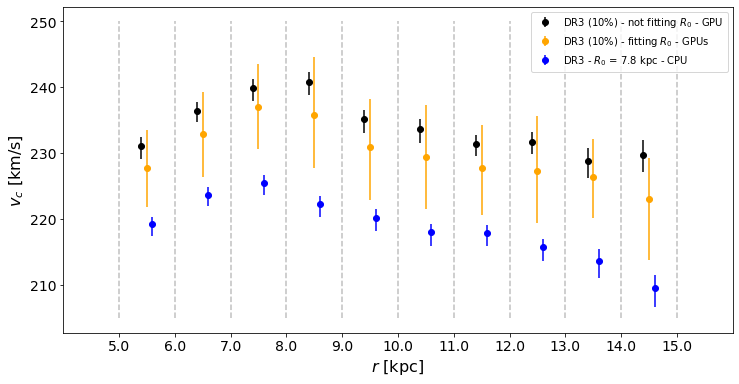

In [32]:
extra_dims = [2, 3, 2]
plot_rotation_curve(False, 
                    paths[1:], 
                    [ 'DR3 (10%) - not fitting $R_0$ - GPU',
                    'DR3 (10%) - fitting $R_0$ - GPUs',
                    'DR3 - $R_0$ = 7.8 kpc - CPU'],
                    [4000, 4000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)



# Comparison With Symmetric Prior

In [5]:
# Fitting only h-params - CPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-24-26_48'

# Fitting all params - GPU
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-03-15-25-27_48'

# Symmetric Prior
path3 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-04-17-25-11_48'

paths=[path1, path2, path3]
labels =[]

samplers=[]
for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (169498, 14)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 1698.6870206849069), (6500.0, 1601.081857629187), (7500.0, 1728.1006902683919), (8500.0, 1789.709481323073), (9500.0, 1858.8133641963743), (10500.0, 1975.2590919652146), (11500.0, 1798.905471840576), (12500.0, 1789.2783824604835), (13500.0, 2456.809

Sampler 1 shape: (13846, 48, 13)
Sampler 2 shape: (7738, 48, 13)


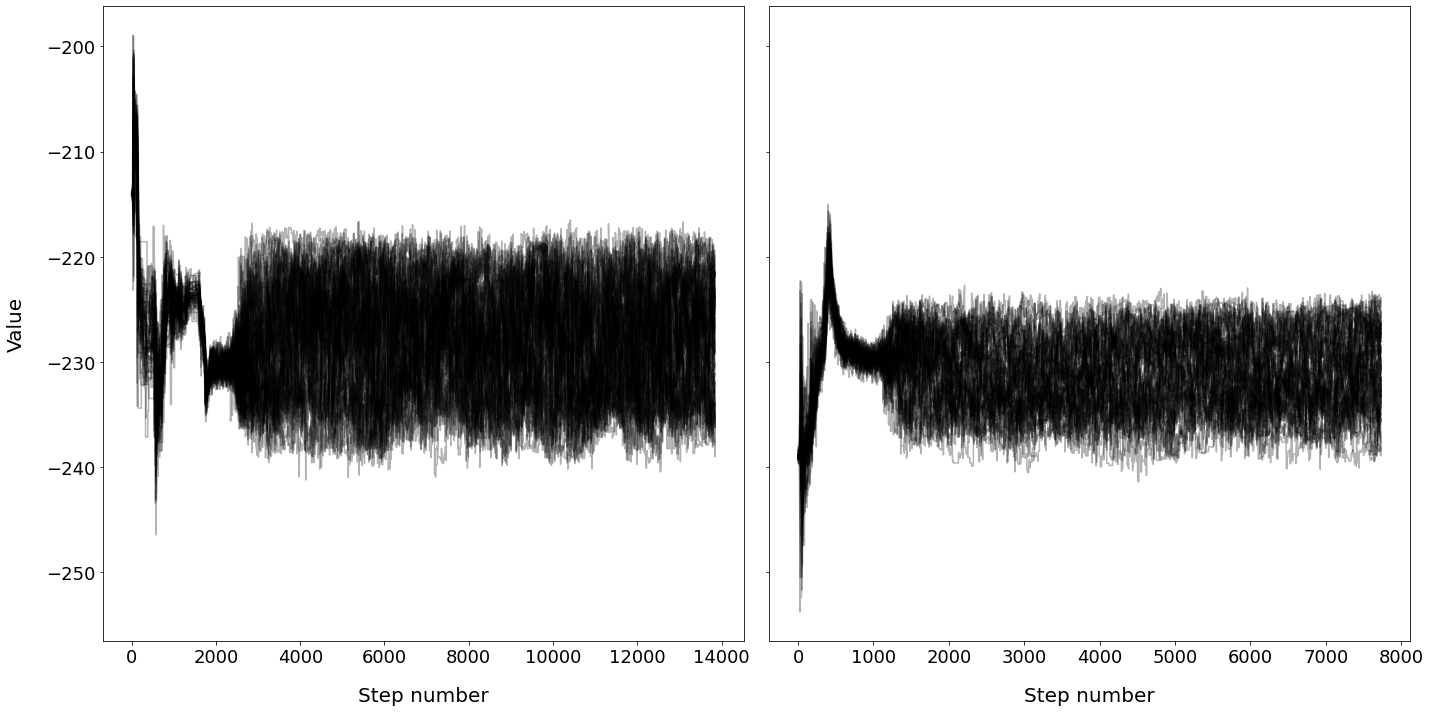

In [6]:
# Comparing results of:
#   1) Non-symmetric
#   2) Symmetric prior

gpu_non = samplers[1]
gpu_sym = samplers[2]
compare_mcmc_runs((gpu_non, gpu_sym), bin_idx  = 0, discard=0)

Sampler 1 shape: (15000, 48, 12)
Sampler 2 shape: (7738, 48, 13)


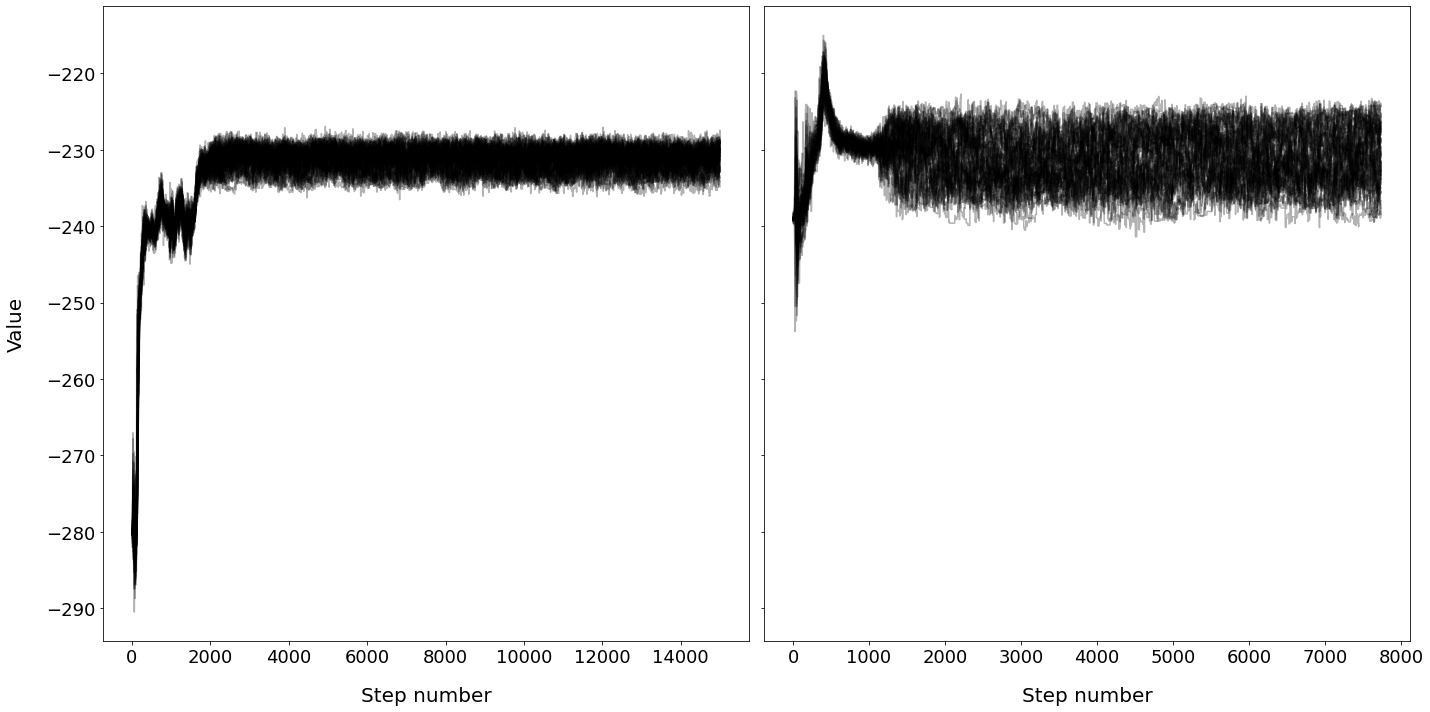

In [9]:
# Comparing results of:
#   1) Not fitting R0
#   2) Symmetric prior

gpu_nofit = samplers[0]
gpu_sym = samplers[2]
compare_mcmc_runs((gpu_nofit, gpu_sym), bin_idx  = 0, discard=0)

R, v_c, sig-, sig+
5.5 231.1 2.0 1.3
6.5 236.4 1.8 1.2
7.5 239.9 1.9 1.3
8.5 240.7 2.0 1.5
9.5 235.1 2.1 1.4
10.5 233.7 2.2 1.5
11.5 231.4 2.0 1.4
12.5 231.7 1.9 1.4
13.5 228.8 2.6 2.0
14.5 229.6 2.7 2.2
(10,)
(10,)
R, v_c, sig-, sig+
5.5 227.8 6.0 5.7
6.5 233.0 6.6 6.4
7.5 236.9 6.3 6.6
8.5 235.8 8.1 8.8
9.5 231.0 8.1 7.2
10.5 229.5 7.9 7.9
11.5 227.8 7.1 6.5
12.5 227.4 8.0 8.3
13.5 226.3 6.1 5.9
14.5 223.1 9.3 6.1
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.2 3.8 3.9
6.5 236.7 3.9 4.3
7.5 240.3 4.2 4.0
8.5 240.6 4.7 5.7
9.5 235.3 5.3 5.0
10.5 233.8 4.9 5.0
11.5 231.6 4.6 4.6
12.5 231.9 4.9 5.3
13.5 229.7 3.8 4.2
14.5 228.4 5.7 6.1
(10,)
(10,)


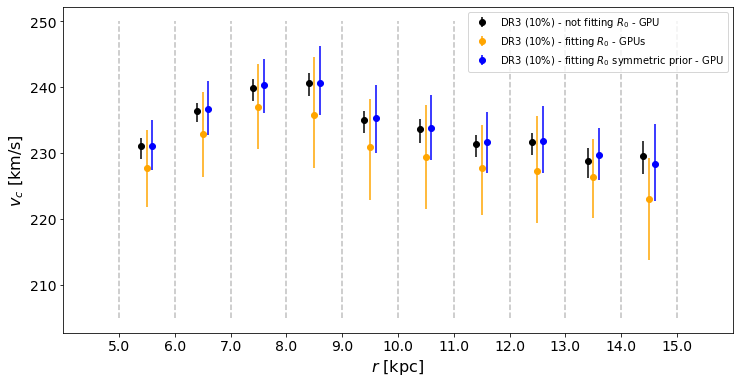

In [8]:
extra_dims = [2, 3, 3]
plot_rotation_curve(False, 
                    paths[:], 
                    [ 'DR3 (10%) - not fitting $R_0$ - GPU',
                    'DR3 (10%) - fitting $R_0$ - GPUs',
                    'DR3 (10%) - fitting $R_0$ symmetric prior - GPU'],
                    [4000, 4000, 3000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)


# Binning Scheme Comparisons

In [29]:
# New Binning 1% Data - GPU
path1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-05-15-12-33_48'

# New Binning 10% Data - GPU
path2 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-05-16-01-14_48'

# Old Binning 10% Data - GPU
path3 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-04-17-25-11_48'

# New Binning, No R0 Fitting
path4 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-06-11-46-41_48_H_FITTING_TEST'

# Old Binning, No R0 Fitting
path5 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-06-13-13-26_48_OLD_BINNING_H_FIT'

# # New Binning, No R0 Fitting, BIN FIXED
path6 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2023-01-06-14-13-30_48_OLD_BINNING_H_FIT_FIXBIN'

paths=[path1, path2, path3, path4, path5, path6]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path2, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (169498, 14)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 1698.6870206849069), (6500.0, 1601.081857629187), (7500.0, 1728.1006902683919), (8500.0, 1789.709481323073), (9500.0, 1858.8133641963743), (10500.0, 1975.2590919652146), (11500.0, 1798.905471840576), (12500.0, 1789.2783824604835), (13500.0, 2456.809

Sampler shape: (5000, 48, 12)


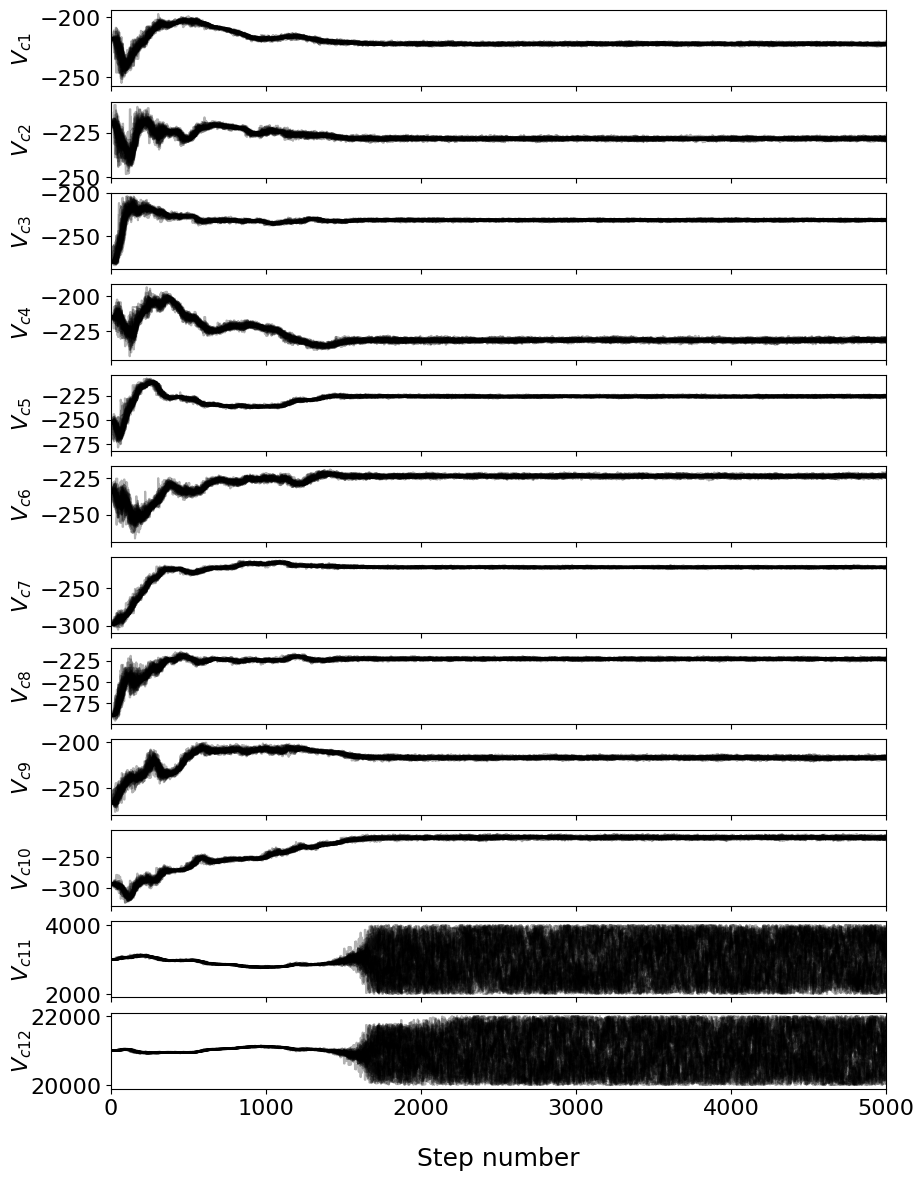

In [13]:
plot_walkers(samplers[-1], 0)

R, v_c, sig-, sig+
5.5 221.0 5.5 3.5
6.5 228.1 5.2 4.4
7.5 229.3 5.1 4.3
8.5 230.6 5.2 4.7
9.5 226.0 5.1 4.4
10.5 223.7 4.8 4.2
11.5 222.6 6.2 4.6
12.5 220.0 6.0 4.5
13.5 218.7 8.0 6.3
14.5 210.7 3.1 3.5
(10,)
(10,)
R, v_c, sig-, sig+
5.5 221.9 4.5 4.0
6.5 228.1 4.6 4.1
7.5 230.9 4.6 4.3
8.5 231.3 4.5 4.1
9.5 225.3 4.7 4.3
10.5 223.4 4.3 4.2
11.5 222.2 4.7 4.3
12.5 222.7 4.3 4.2
13.5 216.9 4.7 4.6
14.5 216.3 2.6 2.4
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.0 4.0 3.9
6.5 236.5 4.1 4.3
7.5 240.1 4.3 4.0
8.5 240.4 4.9 5.8
9.5 235.0 5.5 5.0
10.5 233.6 5.1 5.1
11.5 231.4 4.7 4.6
12.5 231.7 5.1 5.4
13.5 229.5 3.9 4.2
14.5 228.0 5.9 6.0
(10,)
(10,)
R, v_c, sig-, sig+
0.0 222.3 0.6 0.6
0.0 228.4 0.5 0.5
0.0 231.3 0.7 0.7
0.0 231.9 0.8 0.8
0.0 225.8 0.6 0.6
0.0 223.7 0.7 0.6
0.0 222.6 0.7 0.7
0.0 223.0 0.8 0.8
0.0 216.8 1.0 1.0
0.0 217.6 1.5 1.5


IndexError: list index out of range

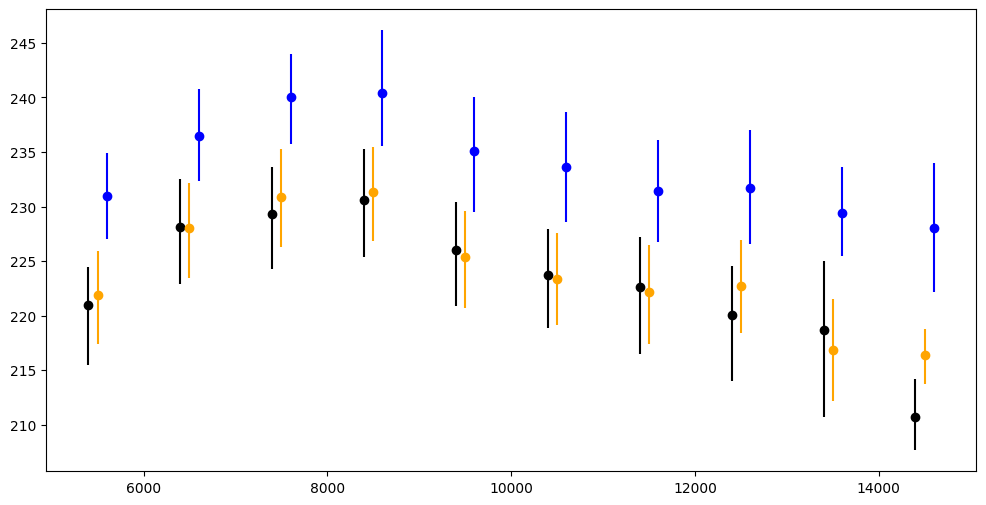

In [8]:
extra_dims = [3, 3, 3]
plot_rotation_curve(False, 
                    paths[:], 
                    [ 'DR3 (1%) - New Binning - GPU',
                     'DR3 (10%) - New Binning - GPU',
                    'DR3 (10%) - Baseline Symmetric Prior (Old binning)'],
                    [2000, 2500, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

R, v_c, sig-, sig+
5.5 221.9 4.5 4.0
6.5 228.1 4.6 4.1
7.5 230.9 4.6 4.3
8.5 231.3 4.5 4.1
9.5 225.3 4.7 4.3
10.5 223.4 4.3 4.2
11.5 222.2 4.7 4.3
12.5 222.7 4.3 4.2
13.5 216.9 4.7 4.6
14.5 216.3 2.6 2.4
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.0 4.0 3.9
6.5 236.5 4.1 4.3
7.5 240.1 4.3 4.0
8.5 240.4 4.9 5.8
9.5 235.0 5.5 5.0
10.5 233.6 5.1 5.1
11.5 231.4 4.7 4.6
12.5 231.7 5.1 5.4
13.5 229.5 3.9 4.2
14.5 228.0 5.9 6.0
(10,)
(10,)
R, v_c, sig-, sig+
0.0 222.3 0.6 0.6
0.0 228.4 0.5 0.5
0.0 231.3 0.7 0.7
0.0 231.9 0.8 0.8
0.0 225.8 0.6 0.6
0.0 223.7 0.7 0.6
0.0 222.6 0.7 0.7
0.0 223.0 0.8 0.8
0.0 216.8 1.0 1.0
0.0 217.6 1.5 1.5
(10,)
(10,)


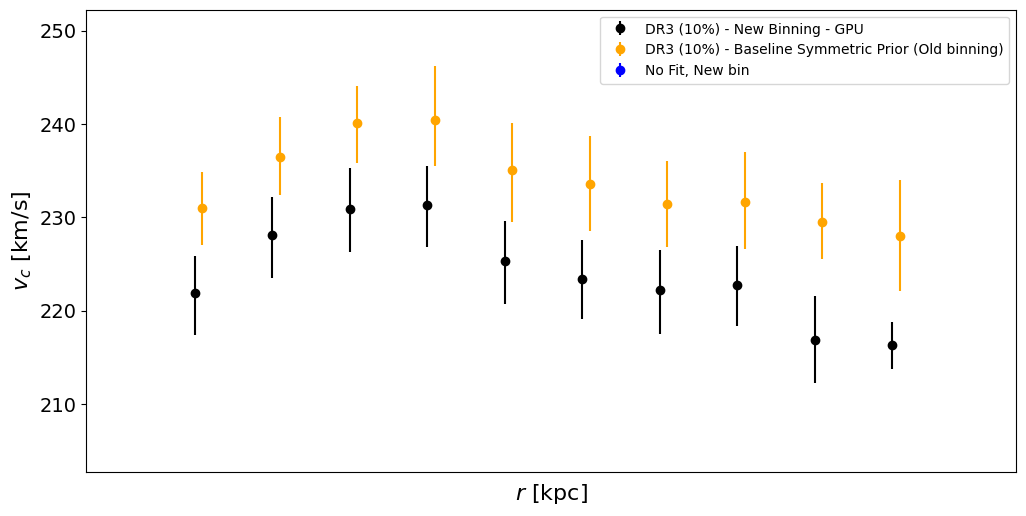

In [10]:
extra_dims = [3, 3, 2]
plot_rotation_curve(False, 
                    [paths[1], paths[2], paths[3]], 
                    [
                     'DR3 (10%) - New Binning - GPU',
                    'DR3 (10%) - Baseline Symmetric Prior (Old binning)',
                    'No Fit, New bin'],
                    [2500, 4000, 2000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

R, v_c, sig-, sig+
5.5 221.9 4.5 4.0
6.5 228.1 4.6 4.1
7.5 230.9 4.6 4.3
8.5 231.3 4.5 4.1
9.5 225.3 4.7 4.3
10.5 223.4 4.3 4.2
11.5 222.2 4.7 4.3
12.5 222.7 4.3 4.2
13.5 216.9 4.7 4.6
14.5 216.3 2.6 2.4
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.0 4.0 3.9
6.5 236.5 4.1 4.3
7.5 240.1 4.3 4.0
8.5 240.4 4.9 5.8
9.5 235.0 5.5 5.0
10.5 233.6 5.1 5.1
11.5 231.4 4.7 4.6
12.5 231.7 5.1 5.4
13.5 229.5 3.9 4.2
14.5 228.0 5.9 6.0
(10,)
(10,)
R, v_c, sig-, sig+
5.5 222.3 0.6 0.6
6.5 228.4 0.5 0.5
7.5 231.3 0.7 0.7
8.5 231.9 0.8 0.8
9.5 225.8 0.6 0.6
10.5 223.7 0.7 0.6
11.5 222.6 0.7 0.7
12.5 223.0 0.8 0.8
13.5 216.8 1.0 1.0
14.5 217.6 1.5 1.5
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.0 2.0 1.3
6.5 236.3 1.8 1.1
7.5 239.8 1.9 1.3
8.5 240.6 2.0 1.5
9.5 235.0 2.1 1.3
10.5 233.5 2.2 1.4
11.5 231.3 1.9 1.3
12.5 231.6 1.8 1.4
13.5 228.6 2.5 1.8
14.5 229.5 2.6 2.1
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.0 1.9 1.4
6.5 236.4 1.7 1.2
7.5 239.7 1.8 1.2
8.5 240.5 1.8 1.4
9.5 235.0 2.0 1.3
10.5 233.5 2.2 1.4
11.5 231

IndexError: list index out of range

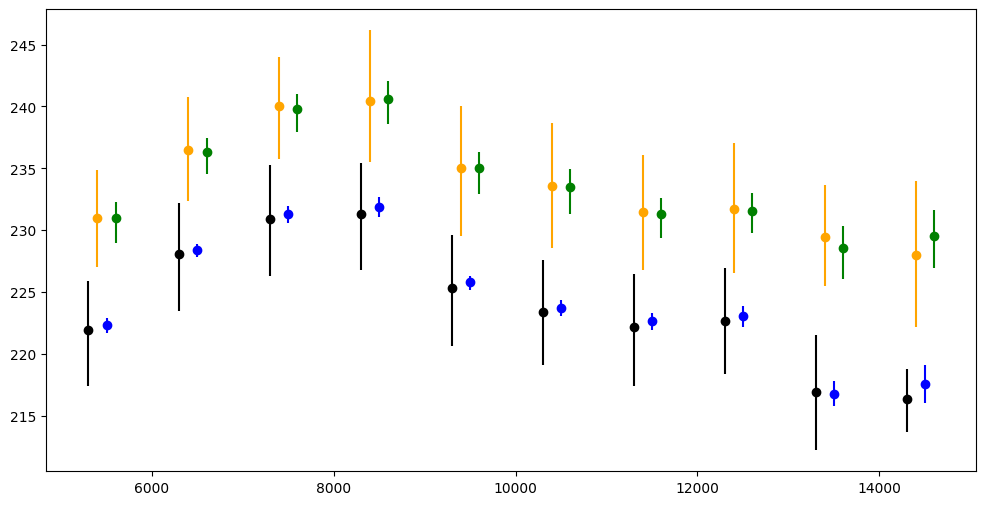

In [32]:
extra_dims = [3, 3, 2, 2, 2]
plot_rotation_curve(False, 
                    [paths[1], paths[2], paths[3], paths[4], paths[5]], 
                    [
                    'DR3 (10%) - R0 Fitting (New binning) - GPU',
                    'DR3 (10%) - R0 Fitting (Old binning) - GPU',
                    'DR3 (10%) - No R0 Fitting (New binning) - CPU',
                    'DR3 (10%) - No R0 Fitting (Old binning) - CPU',
                    'DR3 (10%) - No R0 Fitting (New binning), minor fix - CPU'],
                    [2500, 4000, 2000, 2000, 3500],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)

Sampler shape: (5000, 48, 12)


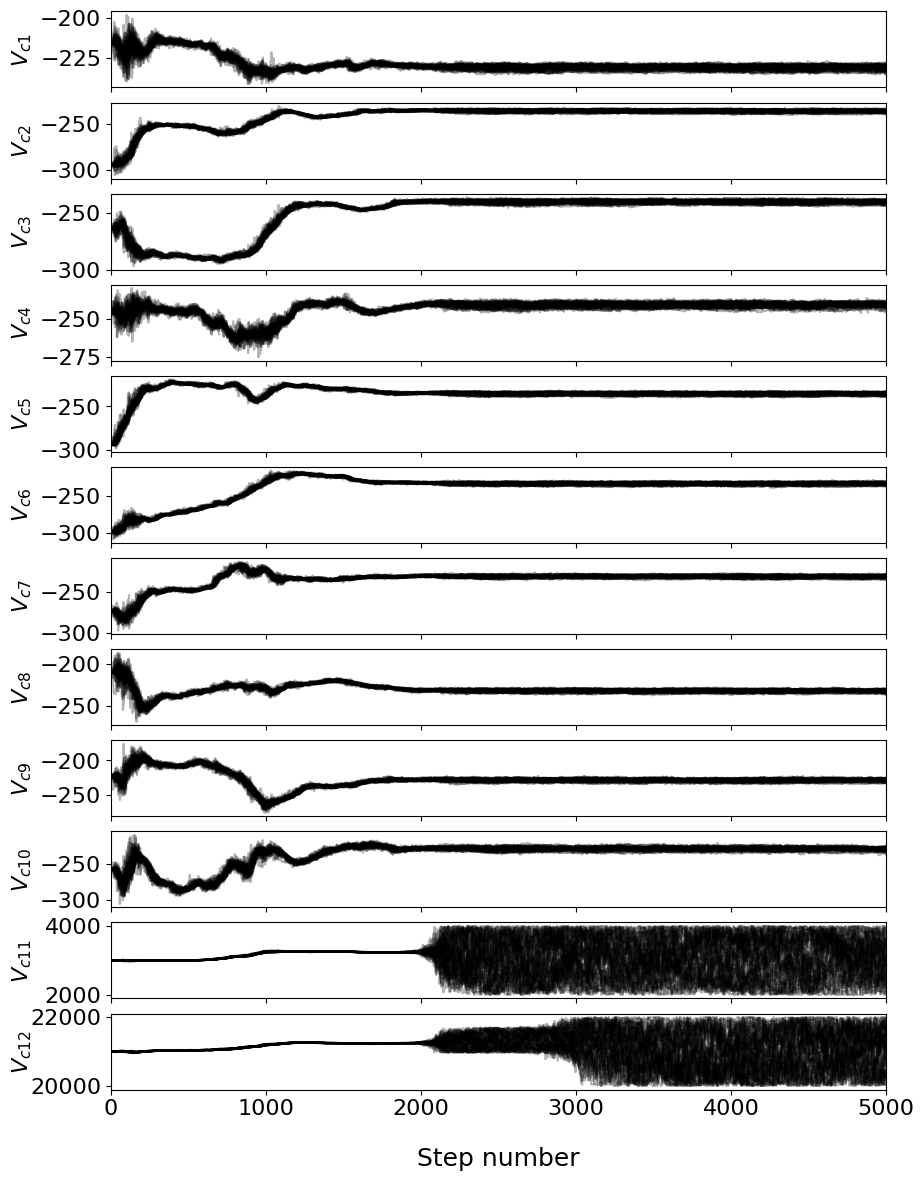

In [31]:
plot_walkers(samplers[-1], 0)

In [13]:
# Fitting R0, New Binning, 10% Data - GPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-06-15-16-50_48_10per_data'

# Fitting R0, Old Binning, 10% Data - GPU
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-04-17-25-11_48'

paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (169498, 14)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 16408077.581503017), (6500.0, 15461526.295841113), (7500.0, 16688434.548663782), (8500.0, 17252653.07789298), (9500.0, 17788124.203594934), (10500.0, 18755757.490353506), (11500.0, 16405597.487279382), (12500.0, 16257553.267221006), (13500.0, 218290

Sampler shape: (5000, 48, 13)


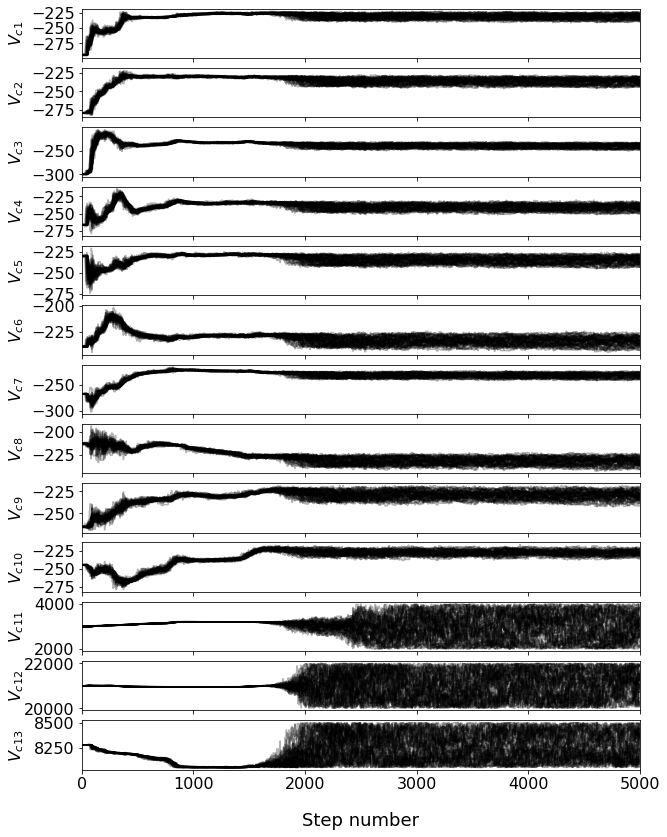

In [18]:
plot_walkers(samplers[0], 0)

R, v_c, sig-, sig+
5.5 230.5 4.9 3.8
6.5 235.9 5.0 4.0
7.5 239.4 5.0 4.0
8.5 240.4 4.8 4.2
9.5 234.7 4.9 4.2
10.5 233.3 4.4 4.0
11.5 230.9 5.1 3.7
12.5 231.3 4.6 4.0
13.5 229.0 5.3 4.3
14.5 228.0 3.7 3.7
(10,)
(10,)
R, v_c, sig-, sig+
5.5 231.0 4.0 3.9
6.5 236.5 4.1 4.3
7.5 240.1 4.3 4.0
8.5 240.4 4.9 5.8
9.5 235.0 5.5 5.0
10.5 233.6 5.1 5.1
11.5 231.4 4.7 4.6
12.5 231.7 5.1 5.4
13.5 229.5 3.9 4.2
14.5 228.0 5.9 6.0
(10,)
(10,)


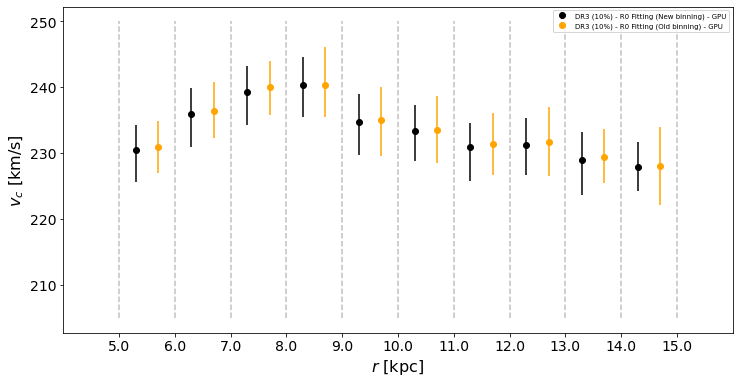

In [17]:
extra_dims = [3, 3]
plot_rotation_curve(False, 
                    [paths[0],paths[1]], 
                    [
                    'DR3 (10%) - R0 Fitting (New binning) - GPU',
                    'DR3 (10%) - R0 Fitting (Old binning) - GPU'
                    ],
                    [3000, 4000],
                    extra_dims=extra_dims,
                    display_eilers=False,
                    display_bin_edges=True)
